# TNEG Geospatial Visualizations

This notebook contains a base map with county-level breakdown for the state of TN.  

The non-geospatial data that is read in here is generated by the dq3-TNEG-geospatial-data-preparation notebook.

In [1]:
# import statements
import pandas as pd
import numpy as np
import requests
import ipywidgets as widgets
#from bs4 import BeautifulSoup as bs
from IPython.core.display import HTML
#import matplotlib.pyplot as plt
import matplotlib as mpl
import pylab as plt
import json
from bokeh.io import output_file, show, output_notebook, export_png
from bokeh.models import ColumnDataSource, GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.models.widgets import DataTable
from bokeh.plotting import figure
from bokeh.palettes import brewer
import panel as pn
import panel.widgets as pnw
#import seaborn as sns
from io import StringIO
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from cartopy.io import shapereader
%matplotlib inline
# import io
# import scipy.stats as stats
# import statsmodels.api as sm

In [2]:
# display settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Create a base map for the state of TN, broken down by county.

In [3]:
# Create a folium map, but probably not the best idea to subsequently join all of the other data
# tn_map = folium.Map(location=[36,-86], zoom_start = 7)
# tn_map

In [4]:
# Create a base map by importing the base shape file for TN census map
# Annoyingly, this is broken down by census division, not by county
# tn_census_map = gpd.read_file('../data/2018-TN-basemap/tl_2016_47_cousub.shp')
# tn_census_map.info()

In [5]:
# Check to see if COUNTYFP |is the right level to aggregate at to get county-level geometries
# tn_census_map['COUNTYFP'].nunique()

In [6]:
# Attempt to aggregate geometries by county - and not succeed
# tn_census_map.groupby('COUNTYFP')['geometry']

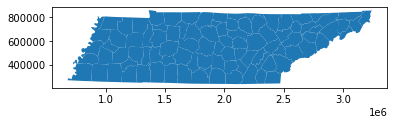

In [7]:
# Ask Michael, get this county-level base map shapefile instead
tn_county_map = gpd.read_file('../data/TN-county-basemap/tncounty.shp')
# See what the map looks like
tn_county_map.plot();

In [8]:
# Take a look at the base map dataframe
tn_county_map.head()

,OBJECTID,NAME,KEY,SHAPE_AREA,SHAPE_LEN,geometry
0,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ..."
1,77,Wayne,47181,2.050741e+10,666520.678598,"POLYGON ((1365052.057 391716.806, 1365746.554 ..."
2,78,Tipton,47167,1.319125e+10,865093.887634,"MULTIPOLYGON (((886814.330 400456.525, 886774...."
3,79,Hamilton,47065,1.604776e+10,652926.001078,"POLYGON ((2274954.438 239788.911, 2274090.610 ..."
4,80,Stewart,47161,1.375003e+10,490090.336180,"POLYGON ((1382472.783 743972.302, 1382445.171 ..."


In [9]:
# Check to make sure nothing is missing
tn_county_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    95 non-null     int64   
 1   NAME        95 non-null     object  
 2   KEY         95 non-null     object  
 3   SHAPE_AREA  95 non-null     float64 
 4   SHAPE_LEN   95 non-null     float64 
 5   geometry    95 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(2)
memory usage: 4.6+ KB


In [10]:
# check the projection type
tn_county_map.crs

<Projected CRS: EPSG:2274>
Name: NAD83 / Tennessee (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - Tennessee
- bounds: (-90.31, 34.98, -81.65, 36.68)
Coordinate Operation:
- name: SPCS83 Tennessee zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [11]:
# change the projection type
tn_county_map = tn_county_map.to_crs('EPSG:4326')
print(tn_county_map.crs)
# Clean up some of the columns we don't need
tn_county_map = tn_county_map.drop(['OBJECTID', 'KEY', 'SHAPE_LEN'], axis = 1)
# Reformat column headers
tn_county_map.columns = ['county', 'shape_area', 'geometry']
# Set the county names to lower case
tn_county_map['county'] = tn_county_map['county'].str.lower()
# Make sure the base map dataset is good to go
tn_county_map.head(2)

EPSG:4326


,county,shape_area,geometry
0,chester,8.049024e+09,"POLYGON ((-88.78177 35.24759, -88.78185 35.247..."
1,wayne,2.050741e+10,"POLYGON ((-88.02474 35.39231, -88.02237 35.390..."


### Read in the non-spatial, county-level aggregations

In [12]:
# Without the percentile rank calcs
# tn_data = pd.read_csv('../data/TN_aggregated_data.csv')
# With percentile rank calcs
tn_data = pd.read_csv('../data/tn_data_pctrnk_risk_calc.csv')
tn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Columns: 104 entries, Unnamed: 0 to risk_calc_norm
dtypes: float64(78), int64(24), object(2)
memory usage: 77.3+ KB


In [13]:
# Get the list of columns to put into the widget
print(tn_data.columns.to_list())

['Unnamed: 0', 'county', 'pct_children_under_18', 'pct_people_living_in_rural_areas', 'pct_people_of_color', 'pct_people_with_disabilities', 'pct_senior_citizens', 'total_housing_units_2019', 'county_full', 'population_est', 'pct_insured', 'race_afam', 'race_asam', 'race_latn', 'race_natam', 'race_paci', 'race_white', 'race_othr', 'race_multi', 'disability_y', 'disability_n', 'edu_lessHS', 'edu_HSgrad', 'edu_assoc', 'edu_min_bac', 'employed_est', 'unemployed_est', 'tot_w_poverty_lvl_data', 'tot_poverty_less100', 'tot_poverty_101_138', 'tot_poverty_138_399', 'tot_poverty_400_up', 'area_miles2', 'socioeconomic', 'household_comp_and_disability', 'minority_status_and_language', 'housing_type_and_transportation', 'total_vulnerability', 'pct_uninsured', 'gdp_2018', 'gdp_per_cap_2018', 'mag_mean', 'mag_median', 'mag_max', 'depth_mean', 'depth_median', 'depth_min', 'num_earthquakes', 'pct_prob_100y_median', 'pct_prob_100y_max', 'pop_density', 'pctrnk_pop_density', 'pct_edu_HSgrad', 'pctrnk_edu

### Merge the non-spatial aggregate dataframe to the base map

In [14]:
# Join in the demographic data to the TN base map
tn_data_map = tn_county_map.merge(tn_data, on = 'county')
# Check to make sure it is a full join
tn_data_map

,county,shape_area,geometry,Unnamed: 0,pct_children_under_18,pct_people_living_in_rural_areas,pct_people_of_color,pct_people_with_disabilities,pct_senior_citizens,total_housing_units_2019,county_full,population_est,pct_insured,race_afam,race_asam,race_latn,race_natam,race_paci,race_white,race_othr,race_multi,disability_y,disability_n,edu_lessHS,edu_HSgrad,edu_assoc,edu_min_bac,employed_est,unemployed_est,tot_w_poverty_lvl_data,tot_poverty_less100,tot_poverty_101_138,tot_poverty_138_399,tot_poverty_400_up,area_miles2,socioeconomic,household_comp_and_disability,minority_status_and_language,housing_type_and_transportation,total_vulnerability,pct_uninsured,gdp_2018,gdp_per_cap_2018,mag_mean,mag_median,mag_max,depth_mean,depth_median,depth_min,num_earthquakes,pct_prob_100y_median,pct_prob_100y_max,pop_density,pctrnk_pop_density,pct_edu_HSgrad,pctrnk_edu_HSgrad,pct_edu_assoc,pctrnk_edu_assoc,pct_edu_min_bac,pctrnk_edu_min_bac,pct_poverty_138_399,pctrnk_poverty_138_399,pct_poverty_400_up,pctrnk_poverty_400_up,pctrnk_gdp_2018,pctrnk_gdp_per_cap_2018,pctrnk_depth_mean,pctrnk_depth_median,pctrnk_depth_min,pctrnk_housing_units,pctrnk_pop_est,pctrnk_uninsured,pctrnk_mag_mean,pctrnk_mag_median,pctrnk_mag_max,pctrnk_earthquakes,pctrnk_prob_100y_median,pctrnk_prob_100y_max,hazard_wcs_both,pctrnk_hazard_wcs_both,exposure_wcs_both,pctrnk_exposure_wcs_both,vulnerability_wcs_both,pctrnk_vul_wcs_both,risk_calc_wcs_both,hazard_wcs,pctrnk_hazard_wcs,exposure_wcs,pctrnk_exposure_wcs,vulnerability_wcs,pctrnk_vul_wcs,risk_calc_wcs,hazard_norm_both,pctrnk_hazard_norm_both,exposure_norm_both,pctrnk_exposure_norm_both,vulnerability_norm_both,pctrnk_vul_norm_both,risk_calc_norm_both,hazard_norm,pctrnk_hazard_norm,exposure_norm,pctrnk_exposure_norm,vulnerability_norm,pctrnk_vul_norm,risk_calc_norm
0,chester,8.049024e+09,"POLYGON ((-88.78177 35.24759, -88.78185 35.247...",11,23.3,65.24,10.6,15.6,14.6,7170,"Chester County, Tennessee",16949,88.0,1745,86,170,7,0,14541,141,402,2373,14576,1449,4317,3049,1785,6366,498,15917,2951,874,8583,3509,285.736117,0.6596,0.4255,0.5106,0.3298,0.5213,12.0,371878.0,21.940999,2.000000,2.000,2.00,5.000000,5.000,5.00,1.0,28.435,31.48,59.316968,0.442105,0.254705,0.705263,0.179893,0.505263,0.105316,0.473684,0.539235,0.021053,0.220456,0.621053,0.778947,0.831579,0.594737,0.584211,0.557895,0.210526,0.252632,0.863158,0.594737,0.573684,0.357895,0.357895,0.821053,0.800000,0.518421,0.505263,3390.252632,0.252632,0.543724,0.589474,0.442105,0.518421,0.505263,0.565789,0.826316,0.543724,0.589474,0.726316,0.584211,0.736842,3390.252632,0.252632,0.543724,0.589474,0.473684,0.584211,0.736842,0.565789,0.826316,0.543724,0.589474,0.936842
1,wayne,2.050741e+10,"POLYGON ((-88.02474 35.39231, -88.02237 35.390...",90,19.6,100.00,8.5,20.1,15.9,7366,"Wayne County, Tennessee",14606,88.8,378,64,284,43,0,13784,15,43,3030,11576,1908,4460,2561,1291,5308,382,14553,2853,1341,7393,2966,734.108826,0.7979,0.1915,0.2979,1.0000,0.8298,11.2,337678.0,23.119129,2.205000,2.205,2.40,4.135000,4.135,1.53,2.0,19.150,23.05,19.896233,0.021053,0.305354,0.221053,0.175339,0.557895,0.088388,0.726316,0.508005,0.189474,0.203807,0.747368,0.810526,0.810526,0.631579,0.631579,0.831579,0.221053,0.210526,0.731579,0.747368,0.778947,0.515789,0.478947,0.547368,0.489474,0.578947,0.584211,2921.572632,0.210526,0.624199,0.715789,0.505263,0.578947,0.584211,0.465789,0.257895,0.624199,0.715789,0.515789,0.609211,0.810526,2921.572632,0.210526,0.624199,0.715789,0.631579,0.609211,0.810526,0.465789,0.257895,0.624199,0.715789,0.757895
2,tipton,1.319125e+10,"MULTIPOLYGON (((-89.62931 35.37836, -89.62944 ...",83,27.2,55.13,20.7,15.5,11.1,24104,"Tipton County, Tennessee",60558,90.6,10832,469,1594,230,94,46116,255,1326,9672,50886,4975,15101,12280,6634,25641,1907,60391,8432,4299,27230,20430,458.403998,0.2234,0.6064,0.6809,0.0638,0.1702,9.4,1172035.0,19.353925,1.939545,1.835,3.20,8.860000,9.900,2.60,22.0,42.450,45.99,132.106178,0.747368,0.249364,0.736842,0.202781,0.200000,0.109548,0.410526,0.450895,0.852632,0.33

In [15]:
# Check to make sure nothing got dropped along the way
tn_data_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 95 entries, 0 to 94
Columns: 106 entries, county to risk_calc_norm
dtypes: float64(79), geometry(1), int64(24), object(2)
memory usage: 79.4+ KB


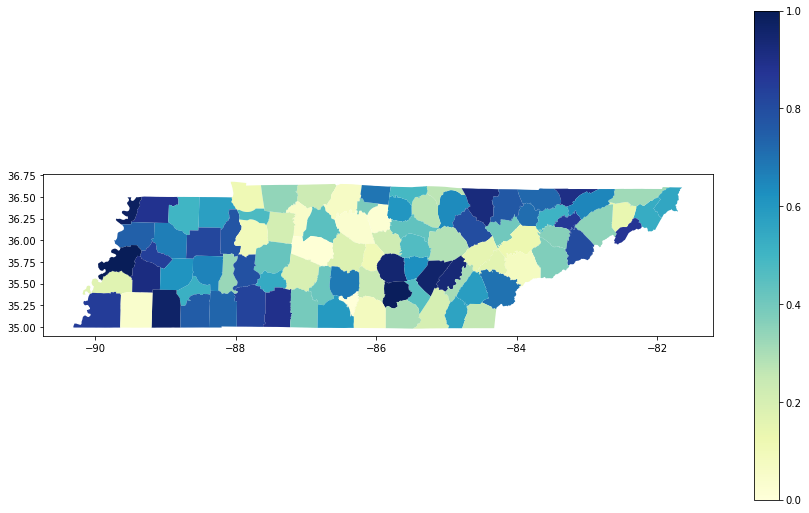

In [16]:
# Start exploring the data visually
ax = tn_data_map.plot(column='total_vulnerability', cmap =    
                                'YlGnBu', figsize=(15,9),   
                                 legend = True)

In [17]:
# Be lazy, get all of the columns so I don't have to type them out
tn_data_map.columns

Index(['county', 'shape_area', 'geometry', 'Unnamed: 0', 'pct_children_under_18', 'pct_people_living_in_rural_areas', 'pct_people_of_color', 'pct_people_with_disabilities', 'pct_senior_citizens', 'total_housing_units_2019',
       ...
       'vulnerability_norm_both', 'pctrnk_vul_norm_both', 'risk_calc_norm_both', 'hazard_norm', 'pctrnk_hazard_norm', 'exposure_norm', 'pctrnk_exposure_norm', 'vulnerability_norm', 'pctrnk_vul_norm', 'risk_calc_norm'], dtype='object', length=106)

''

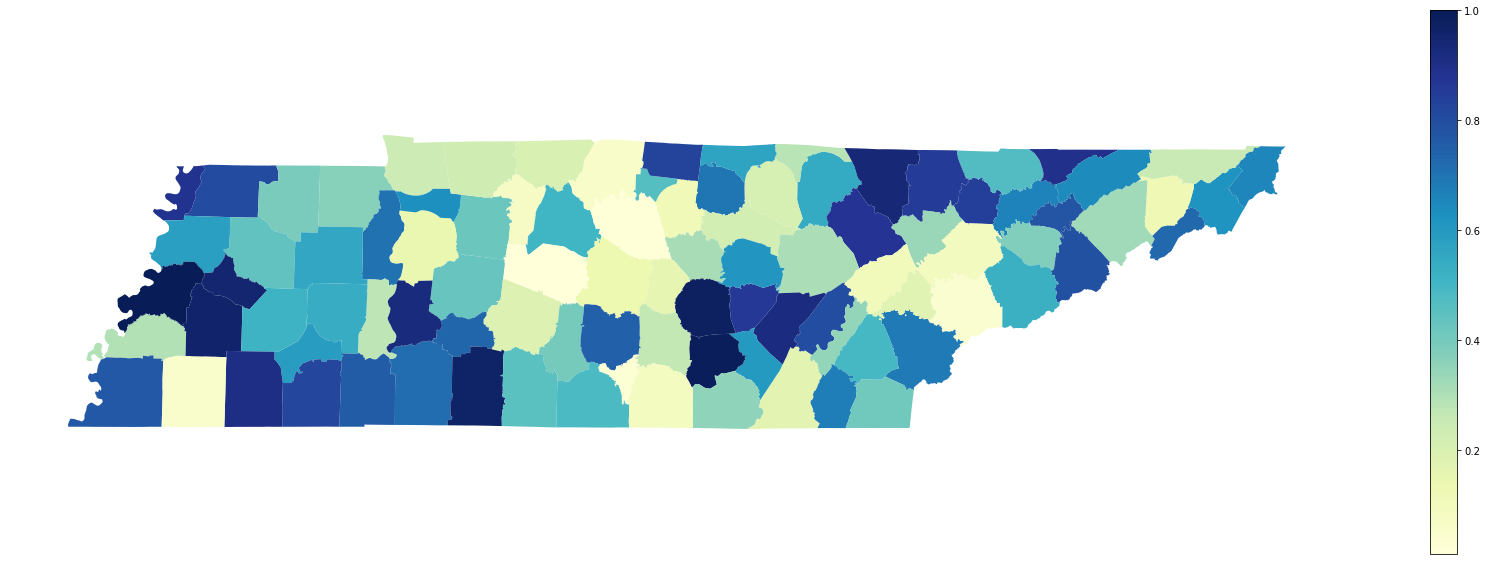

In [18]:
# # 'hazard_wcs_both', 'pctrnk_hazard_wcs_both', 'exposure_wcs_both', \
#               'pctrnk_exposure_wcs_both', 'vulnerability_wcs_both', 'pctrnk_vul_wcs_both', 'risk_calc_wcs_both', \
#               'hazard_wcs', 'pctrnk_hazard_wcs', 'exposure_wcs', 'pctrnk_exposure_wcs', 'vulnerability_wcs', \
#               'pctrnk_vul_wcs', 'risk_calc_wcs', 'hazard_norm_both', 'pctrnk_hazard_norm_both', 'exposure_norm_both', \
#               'pctrnk_exposure_norm_both', 'vulnerability_norm_both', 'pctrnk_vul_norm_both', 'risk_calc_norm_both', \
#               'hazard_norm', 'pctrnk_hazard_norm', 'exposure_norm', 'pctrnk_exposure_norm', 'vulnerability_norm', \
#               'pctrnk_vul_norm', 'risk_calc_norm'
# Start exploring the data visually
ax = tn_data_map.plot(column='pctrnk_vul_norm', cmap =    
                                'YlGnBu', figsize=(30,10),   
                                 legend = True)
plt.axis('off')
plt.savefig('../visualizations/pctrnk_vul_norm.png', dpi = 150)
;

In [19]:
# Build a widget to click through the choropleths based on each of the columns above
# For the dataset without the percentile ranks
# @widgets.interact(
#     column = ['pct_children_under_18', 'pct_people_living_in_rural_areas', \
#               'pct_people_of_color', 'pct_people_with_disabilities', \
#               'pct_senior_citizens', 'total_housing_units_2019', 'county_full', \
#               'population_est', 'pct_insured', 'race_afam', 'race_asam', \
#               'race_latn', 'race_natam', 'race_paci', 'race_white', 'race_othr', \
#               'race_multi', 'disability_y', 'disability_n', 'edu_lessHS', \
#               'edu_HSgrad', 'edu_assoc', 'edu_min_bac', 'employed_est', \
#               'unemployed_est', 'tot_w_poverty_lvl_data', 'tot_poverty_less100', \
#               'tot_poverty_101_138', 'tot_poverty_138_399', 'tot_poverty_400_up', \
#               'area_miles2', 'socioeconomic', 'household_comp_and_disability', \
#               'minority_status_and_language', 'housing_type_and_transportation', \
#               'total_vulnerability', 'pct_uninsured', 'gdp_2018', 'gdp_per_cap_2018', \
#               'mag_mean', 'mag_median', 'mag_max', 'depth_mean', 'depth_median', \
#               'depth_min', 'num_earthquakes', 'pct_prob_100y_median', 'pct_prob_100y_max'])

@widgets.interact(
    column = ['county', 'pct_children_under_18', 'pct_people_living_in_rural_areas', 'pct_people_of_color', \
              'pct_people_with_disabilities', 'pct_senior_citizens', 'total_housing_units_2019', 'county_full', \
              'population_est', 'pct_insured', 'race_afam', 'race_asam', 'race_latn', 'race_natam', 'race_paci', \
              'race_white', 'race_othr', 'race_multi', 'disability_y', 'disability_n', 'edu_lessHS', 'edu_HSgrad', \
              'edu_assoc', 'edu_min_bac', 'employed_est', 'unemployed_est', 'tot_w_poverty_lvl_data', \
              'tot_poverty_less100', 'tot_poverty_101_138', 'tot_poverty_138_399', 'tot_poverty_400_up', \
              'area_miles2', 'socioeconomic', 'household_comp_and_disability', 'minority_status_and_language', \
              'housing_type_and_transportation', 'total_vulnerability', 'pct_uninsured', 'gdp_2018', \
              'gdp_per_cap_2018', 'mag_mean', 'mag_median', 'mag_max', 'depth_mean', 'depth_median', 'depth_min', \
              'num_earthquakes', 'pct_prob_100y_median', 'pct_prob_100y_max', 'pop_density', 'pctrnk_pop_density', \
              'pct_edu_HSgrad', 'pctrnk_edu_HSgrad', 'pct_edu_assoc', 'pctrnk_edu_assoc', 'pct_edu_min_bac', \
              'pctrnk_edu_min_bac', 'pct_poverty_138_399', 'pctrnk_poverty_138_399', 'pct_poverty_400_up', \
              'pctrnk_poverty_400_up', 'pctrnk_gdp_2018', 'pctrnk_gdp_per_cap_2018', 'pctrnk_depth_mean', \
              'pctrnk_depth_median', 'pctrnk_depth_min', 'pctrnk_housing_units', 'pctrnk_pop_est', 'pctrnk_uninsured', \
              'pctrnk_mag_mean', 'pctrnk_mag_median', 'pctrnk_mag_max', 'pctrnk_earthquakes', 'pctrnk_prob_100y_median', \
              'pctrnk_prob_100y_max', 'hazard_wcs_both', 'pctrnk_hazard_wcs_both', 'exposure_wcs_both', \
              'pctrnk_exposure_wcs_both', 'vulnerability_wcs_both', 'pctrnk_vul_wcs_both', 'risk_calc_wcs_both', \
              'hazard_wcs', 'pctrnk_hazard_wcs', 'exposure_wcs', 'pctrnk_exposure_wcs', 'vulnerability_wcs', \
              'pctrnk_vul_wcs', 'risk_calc_wcs', 'hazard_norm_both', 'pctrnk_hazard_norm_both', 'exposure_norm_both', \
              'pctrnk_exposure_norm_both', 'vulnerability_norm_both', 'pctrnk_vul_norm_both', 'risk_calc_norm_both', \
              'hazard_norm', 'pctrnk_hazard_norm', 'exposure_norm', 'pctrnk_exposure_norm', 'vulnerability_norm', \
              'pctrnk_vul_norm', 'risk_calc_norm'])
def throw_some_shade(column):
    """
    Change the choropleth based on the column value
    """
    ax = tn_data_map.plot(column=column, cmap =    
                                'YlGnBu', figsize=(30,10),   
                                 legend = True)
    plt.axis('off')

#widgets.interact(throw_some_shade, col=['total_pop', 'pct_children_under_18', 'pct_people_living_in_rural_areas']);

interactive(children=(Dropdown(description='column', options=('county', 'pct_children_under_18', 'pct_people_l…

### Add the USGS earthquakes since 1900 to the enriched TN base map

In [20]:
usgs = pd.read_csv('../data/tn_usgs.csv')

In [21]:
# Create a geometry column
usgs['geometry'] = usgs.apply(lambda x: Point((float(x.longitude),
                                            float(x.latitude))),
                              axis = 1)
# Make sure it worked
usgs.head()

,Unnamed: 0,time,latitude,longitude,depth,mag,magType,place,type,geometry
0,0,2020-10-21T21:49:45.720Z,36.070500,-89.802333,6.84,2.14,md,"2 km NNE of Cooter, Missouri",earthquake,POINT (-89.8023333 36.0705)
1,1,2020-10-21T20:28:42.930Z,36.525000,-89.569167,6.85,1.69,md,"3 km E of Marston, Missouri",earthquake,POINT (-89.5691667 36.525)
2,2,2020-10-21T04:55:51.350Z,36.545667,-89.649000,8.01,1.61,md,"4 km NW of Marston, Missouri",earthquake,POINT (-89.649 36.5456667)
3,3,2020-10-21T03:00:08.800Z,36.313667,-89.536167,9.50,1.23,md,"7 km NW of Ridgely, Tennessee",earthquake,POINT (-89.5361667 36.3136667)
4,4,2020-10-20T18:50:21.800Z,36.267500,-89.523333,8.84,2.33,md,"3 km W of Ridgely, Tennessee",earthquake,POINT (-89.5233333 36.2675)


In [22]:
# Turn the USGS dataframe into a Geo DataFrame
usgs_geo = gpd.GeoDataFrame(usgs,
                            crs = tn_county_map.crs,
                            geometry = usgs['geometry'])

In [23]:
# Join the USGS data to the enriched TN basemap
tn_earthquakes = gpd.sjoin(usgs_geo, tn_data_map, op = 'within')
tn_earthquakes

,Unnamed: 0_left,time,latitude,longitude,depth,mag,magType,place,type,geometry,index_right,county,shape_area,Unnamed: 0_right,pct_children_under_18,pct_people_living_in_rural_areas,pct_people_of_color,pct_people_with_disabilities,pct_senior_citizens,total_housing_units_2019,county_full,population_est,pct_insured,race_afam,race_asam,race_latn,race_natam,race_paci,race_white,race_othr,race_multi,disability_y,disability_n,edu_lessHS,edu_HSgrad,edu_assoc,edu_min_bac,employed_est,unemployed_est,tot_w_poverty_lvl_data,tot_poverty_less100,tot_poverty_101_138,tot_poverty_138_399,tot_poverty_400_up,area_miles2,socioeconomic,household_comp_and_disability,minority_status_and_language,housing_type_and_transportation,total_vulnerability,pct_uninsured,gdp_2018,gdp_per_cap_2018,mag_mean,mag_median,mag_max,depth_mean,depth_median,depth_min,num_earthquakes,pct_prob_100y_median,pct_prob_100y_max,pop_density,pctrnk_pop_density,pct_edu_HSgrad,pctrnk_edu_HSgrad,pct_edu_assoc,pctrnk_edu_assoc,pct_edu_min_bac,pctrnk_edu_min_bac,pct_poverty_138_399,pctrnk_poverty_138_399,pct_poverty_400_up,pctrnk_poverty_400_up,pctrnk_gdp_2018,pctrnk_gdp_per_cap_2018,pctrnk_depth_mean,pctrnk_depth_median,pctrnk_depth_min,pctrnk_housing_units,pctrnk_pop_est,pctrnk_uninsured,pctrnk_mag_mean,pctrnk_mag_median,pctrnk_mag_max,pctrnk_earthquakes,pctrnk_prob_100y_median,pctrnk_prob_100y_max,hazard_wcs_both,pctrnk_hazard_wcs_both,exposure_wcs_both,pctrnk_exposure_wcs_both,vulnerability_wcs_both,pctrnk_vul_wcs_both,risk_calc_wcs_both,hazard_wcs,pctrnk_hazard_wcs,exposure_wcs,pctrnk_exposure_wcs,vulnerability_wcs,pctrnk_vul_wcs,risk_calc_wcs,hazard_norm_both,pctrnk_hazard_norm_both,exposure_norm_both,pctrnk_exposure_norm_both,vulnerability_norm_both,pctrnk_vul_norm_both,risk_calc_norm_both,hazard_norm,pctrnk_hazard_norm,exposure_norm,pctrnk_exposure_norm,vulnerability_norm,pctrnk_vul_norm,risk_calc_norm
3,3,2020-10-21T03:00:08.800Z,36.313667,-89.536167,9.50,1.23,md,"7 km NW of Ridgely, Tennessee",earthquake,POINT (-89.53617 36.31367),24,lake,5.402735e+09,47,16.7,100.00,29.8,25.6,13.7,2596,"Lake County, Tennessee",4831,89.8,981,10,131,11,0,3614,35,94,1114,3717,752,1275,716,431,1763,208,4714,1268,471,1815,1160,165.784957,1.0000,0.5000,0.4787,0.9574,0.9787,10.2,210981.0,43.672325,1.530109,1.50,3.3,6.815432,6.77,0.0,2118.0,60.610,61.42,29.140159,0.063158,0.263921,0.663158,0.148209,0.905263,0.089215,0.705263,0.385023,0.989474,0.246076,0.452632,0.905263,0.210526,0.463158,0.452632,0.978947,0.010526,0.010526,0.547368,0.336842,0.326316,0.836842,1.000000,1.000000,1.000000,0.953947,0.989474,966.437895,0.010526,0.698122,0.884211,0.757895,0.953947,0.989474,0.297368,0.031579,0.698122,0.884211,0.747368,0.694737,0.968421,966.437895,0.010526,0.698122,0.884211,0.526316,0.694737,0.968421,0.297368,0.031579,0.698122,0.884211,0.768421
4,4,2020-10-20T18:50:21.800Z,36.267500,-89.523333,8.84,2.33,md,"3 km W of Ridgely, Tennessee",earthquake,POINT (-89.52333 36.26750),24,lake,5.402735e+09,47,16.7,100.00,29.8,25.6,13.7,2596,"Lake County, Tennessee",4831,89.8,981,10,131,11,0,3614,35,94,1114,3717,752,1275,716,431,1763,208,4714,1268,471,1815,1160,165.784957,1.0000,0.5000,0.4787,0.9574,0.9787,10.2,210981.0,43.672325,1.530109,1.50,3.3,6.815432,6.77,0.0,2118.0,60.610,61.42,29.140159,0.063158,0.263921,0.663158,0.148209,0.905263,0.089215,0.705263,0.385023,0.989474,0.246076,0.452632,0.905263,0.210526,0.463158,0.452632,0.978947,0.010526,0.010526,0.547368,0.336842,0.326316,0.836842,1.000000,1.000000,1.000000,0.953947,0.989474,966.437895,0.010526,0.698122,0.884211,0.757895,0.953947,0.989474,0.297368,0.031579,0.698122,0.884211,0.747368,0.694737,0.968421,966.437895,0.010526,0.698122,0.884211,0.526316,0.694737,0.968421,0.297368,0.031579,0.698122,0.884211,0.768421
6,6,2020-10-19T20:31:16.660Z,36.419667,-89.499000,7.78,1.30,md,southeastern Missouri,earthquake,POINT (-89.49900 36.41967),24,lake,5.402735e+09,47,16.7,100.00,29.8,25.6,13.7,2596,"Lake County, Tennessee",4831,89.8,981,10,131,11,0,3614,35,94,1114,3717,752,1275

In [24]:
# Remove non-earthquake data
tn_earthquakes = tn_earthquakes[tn_earthquakes['type'] == 'earthquake']
# Cleanup an unnecessary column
tn_earthquakes = tn_earthquakes.drop(['index_right'], axis = 1)
tn_earthquakes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4270 entries, 3 to 7637
Columns: 115 entries, Unnamed: 0_left to risk_calc_norm
dtypes: float64(83), geometry(1), int64(25), object(6)
memory usage: 3.8+ MB


### Visualize some earthquakes and stuff

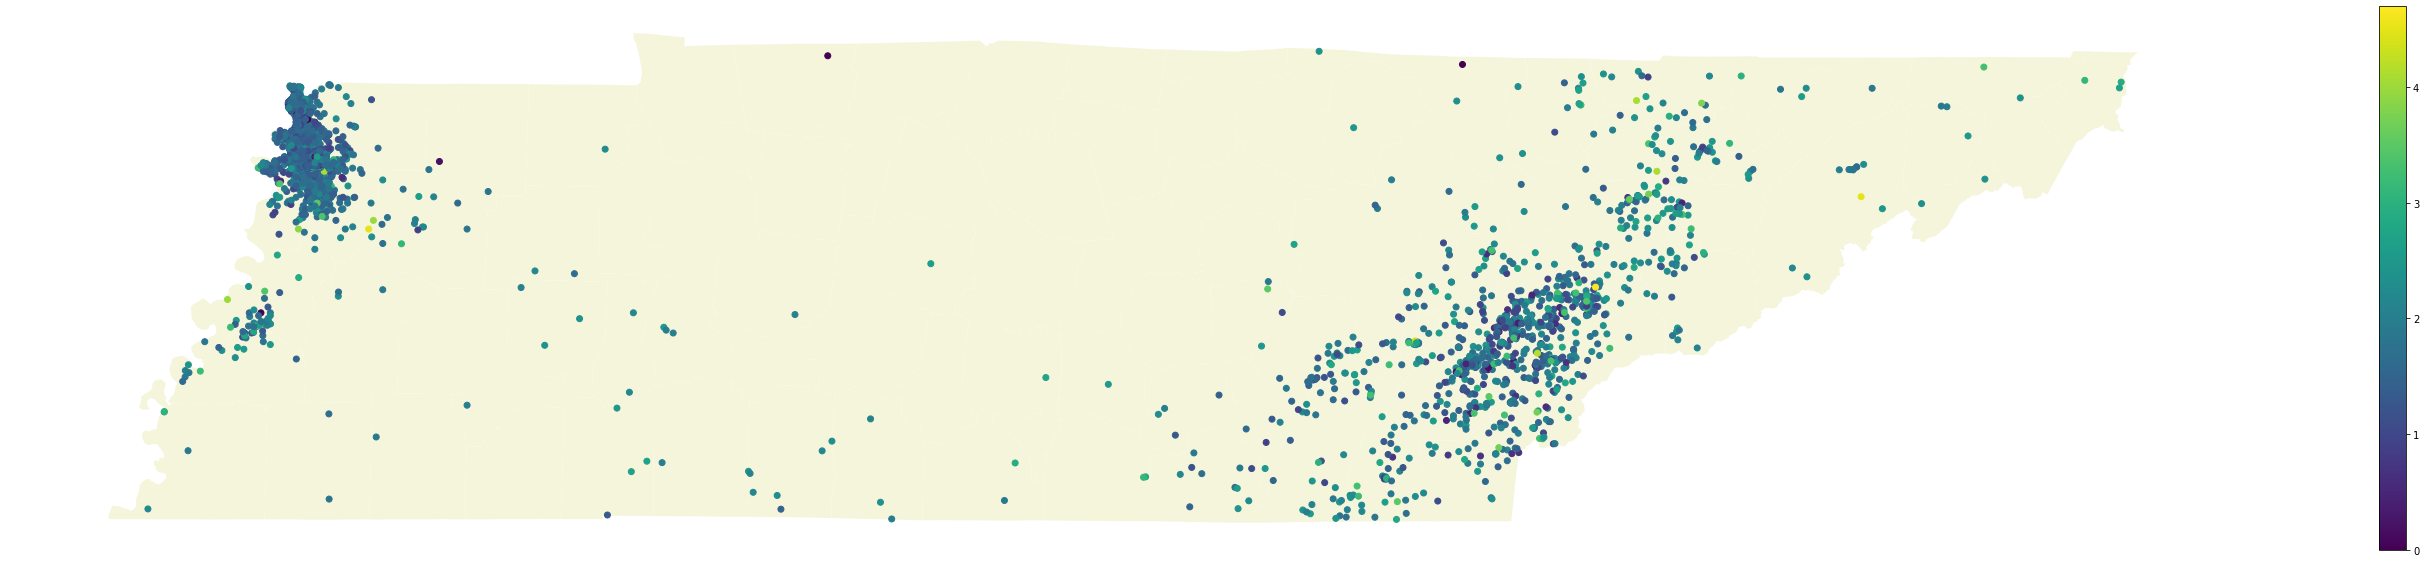

In [25]:
# map the earthquakes, color-coded by magnitute
ax = tn_county_map.plot(figsize = (50, 10), color = 'beige')
tn_earthquakes.plot( ax = ax, column = 'mag', legend = True)
plt.axis('off')
plt.savefig('../visualizations/tn_earthquakes_by_mag.png', dpi = 150)
plt.show();

In [26]:
tn_earthquakes.describe()

,Unnamed: 0_left,latitude,longitude,depth,mag,shape_area,Unnamed: 0_right,pct_children_under_18,pct_people_living_in_rural_areas,pct_people_of_color,pct_people_with_disabilities,pct_senior_citizens,total_housing_units_2019,population_est,pct_insured,race_afam,race_asam,race_latn,race_natam,race_paci,race_white,race_othr,race_multi,disability_y,disability_n,edu_lessHS,edu_HSgrad,edu_assoc,edu_min_bac,employed_est,unemployed_est,tot_w_poverty_lvl_data,tot_poverty_less100,tot_poverty_101_138,tot_poverty_138_399,tot_poverty_400_up,area_miles2,socioeconomic,household_comp_and_disability,minority_status_and_language,housing_type_and_transportation,total_vulnerability,pct_uninsured,gdp_2018,gdp_per_cap_2018,mag_mean,mag_median,mag_max,depth_mean,depth_median,depth_min,num_earthquakes,pct_prob_100y_median,pct_prob_100y_max,pop_density,pctrnk_pop_density,pct_edu_HSgrad,pctrnk_edu_HSgrad,pct_edu_assoc,pctrnk_edu_assoc,pct_edu_min_bac,pctrnk_edu_min_bac,pct_poverty_138_399,pctrnk_poverty_138_399,pct_poverty_400_up,pctrnk_poverty_400_up,pctrnk_gdp_2018,pctrnk_gdp_per_cap_2018,pctrnk_depth_mean,pctrnk_depth_median,pctrnk_depth_min,pctrnk_housing_units,pctrnk_pop_est,pctrnk_uninsured,pctrnk_mag_mean,pctrnk_mag_median,pctrnk_mag_max,pctrnk_earthquakes,pctrnk_prob_100y_median,pctrnk_prob_100y_max,hazard_wcs_both,pctrnk_hazard_wcs_both,exposure_wcs_both,pctrnk_exposure_wcs_both,vulnerability_wcs_both,pctrnk_vul_wcs_both,risk_calc_wcs_both,hazard_wcs,pctrnk_hazard_wcs,exposure_wcs,pctrnk_exposure_wcs,vulnerability_wcs,pctrnk_vul_wcs,risk_calc_wcs,hazard_norm_both,pctrnk_hazard_norm_both,exposure_norm_both,pctrnk_exposure_norm_both,vulnerability_norm_both,pctrnk_vul_norm_both,risk_calc_norm_both,hazard_norm,pctrnk_hazard_norm,exposure_norm,pctrnk_exposure_norm,vulnerability_norm,pctrnk_vul_norm,risk_calc_norm
count,4270.000000,4270.000000,4270.000000,4266.000000,4268.000000,4.270000e+03,4270.00000,4270.000000,4270.00000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4.270000e+03,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000
mean,4133.919906,36.113291,-88.256240,8.657651,1.663163,9.802412e+09,44.54192,19.992998,76.84104,20.402951,22.122365,14.767728,15927.774239,33670.538173,89.918665,3416.287822,359.371194,1373.730211,115.149649,19.485012,27776.734426,314.603513,703.954567,5838.077986,27832.460187,3323.316862,7968.516628,6302.981499,5135.473302,13694.599766,927.432319,33262.003279,5788.688056,2769.615925,14990.062061,9713.637237,330.904179,0.749717,0.569578,0.568482,0.702805,0.800396,10.081335,1.584169e+06,41.531943,1.663042,1.623471,3.552663,8.656423,8.586356,0.661585,1205.960187,49.478813,52.641035,79.358089,0.317335,0.264550,0.625325,0.166721,0.660461,0.104171,0.570635,0.428896,0.801274,0.250090,0.452646,0.632033,0.283693,0.390117,0.379375,0.903014,0.311325,0.310544,0.500467,0.399609,0.387779,0.858832,0.965060,0.910833,0.916296,0.910800,0.956787,6734.416512,0.310544,0.610281,0.719

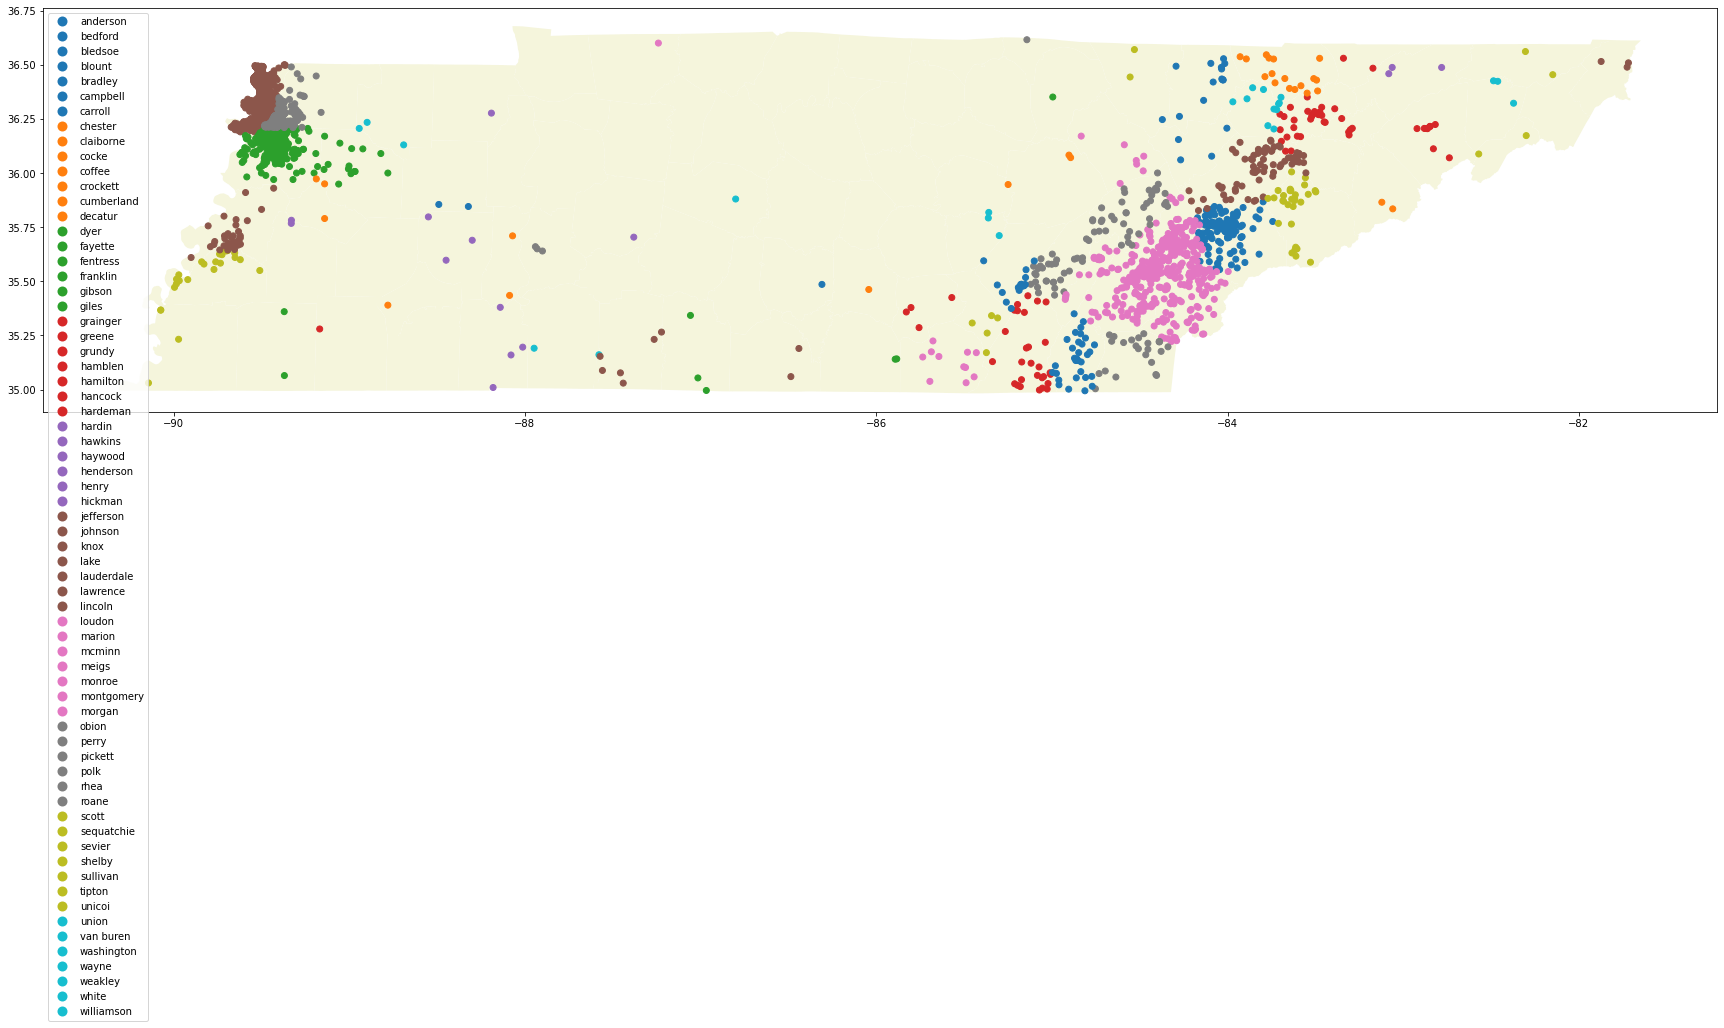

In [27]:
# map the earthquakes, color-coded by county
# not especially useful
ax = tn_county_map.plot(figsize = (30, 10), color = 'beige')
tn_earthquakes.plot( ax = ax, column = 'county', legend = True)
plt.show();

In [28]:
# Since 1900, how many earthquakes per county?
tn_earthquakes['county'].value_counts()

lake          2118
dyer           644
obion          391
monroe         210
blount         135
loudon         100
mcminn          91
knox            59
lauderdale      40
rhea            38
bradley         36
roane           35
sevier          30
grainger        29
hamilton        28
meigs           28
polk            24
tipton          22
bledsoe         18
claiborne       17
jefferson       14
gibson          14
campbell        14
marion          11
union           11
greene          10
morgan           7
lawrence         6
sequatchie       5
hamblen          5
shelby           4
anderson         4
grundy           4
hardin           4
perry            3
cumberland       3
crockett         3
washington       3
weakley          3
johnson          3
giles            3
hawkins          3
henderson        3
sullivan         2
franklin         2
lincoln          2
wayne            2
van buren        2
hancock          2
cocke            2
decatur          2
scott            2
haywood     

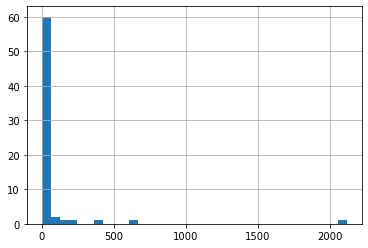

In [29]:
tn_earthquakes['county'].value_counts().hist(bins = 35);

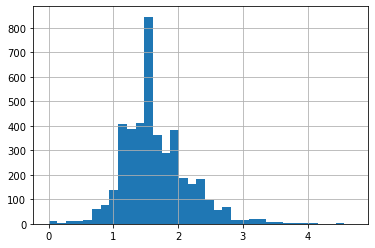

In [30]:
tn_earthquakes['mag'].hist(bins = 35);

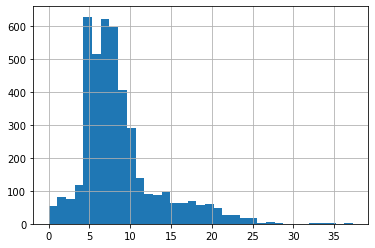

In [31]:
tn_earthquakes['depth'].hist(bins = 35);